# Kelompok 5 - Clustering with K-Means
Final Project Text Mining (C)
1. Adinda Fatimah Az-Zahra (215150201111058)
2. Safir Magenta Putri Bastomi (215150201111021)
3. Tsabita Muthia Ayu Pramesti (215150201111070)
4. BAGAS ANTARINO PUTRA SUMARYUNUS HANING (215150200111006)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_json('/content/drive/MyDrive/ub.json')
df.head()

,title,url,publisher,cited,year,quartile
0,Genetic Diversity of Gorontalo Local Cattle Ba...,https://www.scopus.com/record/display.uri?eid=...,Advances in Animal and Veterinary Sciences,0,2023,Q3 Journal
1,Consumers’ Preference and Future Consideration...,https://www.scopus.com/record/display.uri?eid=...,Agris On-line Papers in Economics and Informatics,0,2023,Q2 Journal
2,A meta-analysis of the effects of clay mineral...,https://www.scopus.com/record/display.uri?eid=...,Poultry Science,7,2023,Q1 Journal
3,Identification and Analysis of Geotourism Pote...,https://www.scopus.com/record/display.uri?eid=...,AIP Conference Proceedings,1,2023,Q4 Journal
4,Epipsammic Diatom Cocconesis sp. as New Bioero...,https://www.scopus.com/record/display.uri?eid=...,Jurnal Ilmiah Perikanan dan Kelautan,0,2023,Q4 Journal


# Preprocessing

In [4]:
!pip install nltk

In [5]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


In [6]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=1aed810097faaa16c974b86dd35525d3b4f3001f0ddf49628002e8aebdf21ba8
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [7]:
import re
import string
from collections import Counter
import math
from collections import OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from langdetect import detect

Melakukan Drop kolom url, cited, year, quartile

In [8]:
hapus = ['url', 'cited', 'year', 'quartile']
df = df.drop(columns=hapus)

df.head()

,title,publisher
0,Genetic Diversity of Gorontalo Local Cattle Ba...,Advances in Animal and Veterinary Sciences
1,Consumers’ Preference and Future Consideration...,Agris On-line Papers in Economics and Informatics
2,A meta-analysis of the effects of clay mineral...,Poultry Science
3,Identification and Analysis of Geotourism Pote...,AIP Conference Proceedings
4,Epipsammic Diatom Cocconesis sp. as New Bioero...,Jurnal Ilmiah Perikanan dan Kelautan


* Menghapus baris data yang duplikat.

In [9]:
print("Jumlah data duplikat (awal):", df.duplicated().sum())
df = df.drop_duplicates(keep='first').reset_index(drop=True)
print("Jumlah data duplikat (akhir):", df.duplicated().sum())

df.head()

Jumlah data duplikat (awal): 4089
Jumlah data duplikat (akhir): 0


,title,publisher
0,Genetic Diversity of Gorontalo Local Cattle Ba...,Advances in Animal and Veterinary Sciences
1,Consumers’ Preference and Future Consideration...,Agris On-line Papers in Economics and Informatics
2,A meta-analysis of the effects of clay mineral...,Poultry Science
3,Identification and Analysis of Geotourism Pote...,AIP Conference Proceedings
4,Epipsammic Diatom Cocconesis sp. as New Bioero...,Jurnal Ilmiah Perikanan dan Kelautan


In [10]:
df.describe()

,title,publisher
count,7367,7367
unique,7347,2082
top,Preface,IOP Conference Series: Earth and Environmental...
freq,4,835


* Menghapus data dari index ke 1001 hingga 7367 agar data yang diolah selalu sama (index 0-1000).

In [11]:
index_todelete = range(1001, 7367)
df.drop(df.index[index_todelete], inplace=True)

In [12]:
df.describe()

,title,publisher
count,1001,1001
unique,992,591
top,Rule of thumb for simulating biomass pyrolysis...,Journal of Applied Sciences Research
freq,3,24


In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

* Mengimplementasikan case folding, menghapus karakter angka, menghapus semua karakter selain huruf a-z, menghapus kata journal dan jurnal.

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\b(?:journal|jurnal)\w*\b', '', text)

    return text

* Melakukan lexical analysis atau tokenizing yaitu pemotongan string input dari kalimat penyusunnya.

In [16]:
def tokenize_text(text):
    tokens = text.split()
    return tokens

* Melakukan stopwords removal yaitu pemilihan kata-kata
penting dari hasil token.



In [17]:
stopword_list = stopwords.words('english')
stemmer_factory = StemmerFactory()
sastrawi_stemmer = stemmer_factory.create_stemmer()

- Stopwords removal Bahasa inggris

In [18]:
def filter_stopwords(tokens, stopwords):
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

- Stopwords removal Bahasa Indonesia

In [19]:
def filter_stopwords_2(tokens, stopword_list):
    file_path = '/content/drive/MyDrive/stopwordlist.txt'
    with open(file_path, 'r') as file:
        stopword_list = [line.strip() for line in file]

    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

* Melakukan stemming untuk mengubah bentuk kata
menjadi kata dasar atau tahap mencari root kata
dari tiap kata hasil filtering.
1. Fungsi pertama untuk bahasa Indonesia
2. Fungsi kedua untuk bahasa Inggris

In [20]:
def stem_tokens(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [21]:
# from nltk.stem import SnowballStemmer

def stem_tokens_2(tokens):
    porter_stemmer = PorterStemmer()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return stemmed_tokens

* Memanggil Seluruh Fungsi untuk diimplementasikan ke fitur title dan publisher.

In [22]:
nama_kolom = 'title', 'publisher'
for i in nama_kolom:
  df[i] = df[i].apply(preprocess_text)
  df[i] = df[i].apply(tokenize_text)
  df[i] = df[i].apply(lambda tokens: filter_stopwords(tokens, stopword_list))
  df[i] = df[i].apply(lambda tokens: filter_stopwords_2(tokens, stopword_list))
df.head()

,title,publisher
0,"[genetic, diversity, gorontalo, local, cattle,...","[advances, animal, veterinary, sciences]"
1,"[consumers, preference, future, consideration,...","[agris, online, papers, economics, informatics]"
2,"[metaanalysis, effects, clay, mineral, supplem...","[poultry, science]"
3,"[identification, analysis, geotourism, potenti...","[aip, conference, proceedings]"
4,"[epipsammic, diatom, cocconesis, sp, new, bioe...","[ilmiah, perikanan, kelautan]"


In [23]:
for i in nama_kolom:
  df[i] = df[i].apply(lambda tokens: stem_tokens(tokens))
  df[i] = df[i].apply(lambda tokens: stem_tokens_2(tokens))
df.head()

,title,publisher
0,"[genet, divers, gorontalo, local, cattl, base,...","[advanc, anim, veterinari, scienc]"
1,"[consum, prefer, futur, consider, toward, orga...","[agri, onlin, paper, econom, informat]"
2,"[metaanalysi, effect, clay, miner, supplement,...","[poultri, scienc]"
3,"[identif, analysi, geotour, potenti, purwodadi...","[aip, confer, proceed]"
4,"[epipsamm, diatom, cocconesi, sp, new, bioerod...","[ilmiah, ikan, laut]"


* Menggabungkan fitur title dan publisher menjadi satu document.

In [24]:
data = pd.DataFrame()
data['combined_term'] = df.apply(lambda row: np.concatenate([row['title'], row['publisher'], [np.nan]*(max(map(len, df['title']))+max(map(len, df['publisher'])) - len(row['title']) - len(row['publisher']))]), axis=1)

data.head()

,combined_term
0,"[genet, divers, gorontalo, local, cattl, base,..."
1,"[consum, prefer, futur, consider, toward, orga..."
2,"[metaanalysi, effect, clay, miner, supplement,..."
3,"[identif, analysi, geotour, potenti, purwodadi..."
4,"[epipsamm, diatom, cocconesi, sp, new, bioerod..."


In [25]:
data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
combined_term,"[genet, divers, gorontalo, local, cattl, base,...","[consum, prefer, futur, consider, toward, orga...","[metaanalysi, effect, clay, miner, supplement,...","[identif, analysi, geotour, potenti, purwodadi...","[epipsamm, diatom, cocconesi, sp, new, bioerod...","[predict, ferment, index, ph, cocoa, theobroma...","[growth, mortal, food, consumpt, exploit, stat...","[extract, character, galactomannan, nipa, palm...","[effect, differ, addit, carbon, dioxid, growth...","[characterist, friction, stir, weld, weld, joi...",...,"[organolept, characterist, egg, laid, local, h...","[rhodamin, b, induc, oxid, stress, cervic, epi...","[parasitemia, induc, high, plasma, level, inte...","[discuss, implic, contribut, manag, scienc, na...","[dispers, yield, loss, variet, resist, sugarca...","[first, report, black, rot, sagittaria, sagitt...","[whey, util, milk, substitut, make, caspian, s...","[predict, rc, beam, failur, load, use, nonline...","[antidiabet, potenti, urena, lobata, leaf, ext...","[ovari, matur, stage, histolog, follicl, diame..."


In [44]:
data['combined_term'] = data['combined_term'].apply(lambda arr: [x for x in arr if x != 'nan'])

data = data[data['combined_term'].apply(len) > 0]

print(data.to_string(index=False))


                                                                                                                                                                                                                                        combined_term
                                                                                                                                                 [genet, divers, gorontalo, local, cattl, base, microsatellit, dna, advanc, anim, veterinari, scienc]
                                                                                                                              [consum, prefer, futur, consider, toward, organ, instant, noodl, evid, indonesia, agri, onlin, paper, econom, informat]
                                                                                                                                       [metaanalysi, effect, clay, miner, supplement, alkalin, phosphatas, broiler, health, perform, poultri, scienc]
                

In [45]:
print(data['combined_term'].tolist())

[['genet', 'divers', 'gorontalo', 'local', 'cattl', 'base', 'microsatellit', 'dna', 'advanc', 'anim', 'veterinari', 'scienc'], ['consum', 'prefer', 'futur', 'consider', 'toward', 'organ', 'instant', 'noodl', 'evid', 'indonesia', 'agri', 'onlin', 'paper', 'econom', 'informat'], ['metaanalysi', 'effect', 'clay', 'miner', 'supplement', 'alkalin', 'phosphatas', 'broiler', 'health', 'perform', 'poultri', 'scienc'], ['identif', 'analysi', 'geotour', 'potenti', 'purwodadi', 'villag', 'malang', 'regenc', 'support', 'geopark', 'area', 'east', 'java', 'aip', 'confer', 'proceed'], ['epipsamm', 'diatom', 'cocconesi', 'sp', 'new', 'bioerod', 'scleractinian', 'coral', 'ilmiah', 'ikan', 'laut'], ['predict', 'ferment', 'index', 'ph', 'cocoa', 'theobroma', 'cacao', 'l', 'bean', 'base', 'color', 'featur', 'cut', 'test', 'partial', 'least', 'squar', 'regress', 'model', 'food', 'scienc', 'technolog', 'unit', 'state'], ['growth', 'mortal', 'food', 'consumpt', 'exploit', 'statu', 'bullet', 'tuna', 'auxi', '

In [46]:
combined_term_list = np.concatenate(data['combined_term'].values)

In [47]:
print(len(combined_term_list))

13773


### Types and Terms

* Memasukkan semua kata hasil stemming ke dalam list bernama combined_term_list untuk diolah types dan termnya.

In [48]:
for term in combined_term_list:
    print(term)

Streaming output truncated to the last 5000 lines.
accuraci
live
weight
metric
bodi
measur
ongol
grade
cow
indonesian
tropic
anim
agricultur
novel
angiotensin
convert
enzym
inhibitori
peptid
deriv
proteolyt
digest
chines
softshel
turtl
egg
white
protein
proteom
investig
airborn
submicromet
particl
emit
dredg
vessel
use
plume
captur
method
atmospher
environ
pb
reduct
avicennia
marina
fruit
flour
soak
citru
aurantifolia
extract
americaneurasian
sustain
agricultur
impact
multicultur
immigr
help
asi
social
psycholog
spectral
characterist
highyield
varieti
rice
plant
use
landsat
data
agrivita
bayesian
spatialtempor
autologist
regress
model
dengu
hemorrhag
fever
case
east
java
indonesia
appli
scienc
research
common
ident
reduc
betweengroup
help
social
psycholog
person
scienc
develop
season
cash
demand
simul
agricultur
cooper
villag
unit
cooper
indonesia
gadjah
mada
intern
busi
spatial
model
dengu
hemorrhag
fever
incid
use
gi
malang
citi
indonesia
european
scientif
research
infant
feed
practi

* Menampilkan dataframe data yang berisi kumpulan gabungkan fitur title dan publisher menjadi satu document.

In [49]:
data.head()

,combined_term
0,"[genet, divers, gorontalo, local, cattl, base,..."
1,"[consum, prefer, futur, consider, toward, orga..."
2,"[metaanalysi, effect, clay, miner, supplement,..."
3,"[identif, analysi, geotour, potenti, purwodadi..."
4,"[epipsamm, diatom, cocconesi, sp, new, bioerod..."


In [50]:
data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
combined_term,"[genet, divers, gorontalo, local, cattl, base,...","[consum, prefer, futur, consider, toward, orga...","[metaanalysi, effect, clay, miner, supplement,...","[identif, analysi, geotour, potenti, purwodadi...","[epipsamm, diatom, cocconesi, sp, new, bioerod...","[predict, ferment, index, ph, cocoa, theobroma...","[growth, mortal, food, consumpt, exploit, stat...","[extract, character, galactomannan, nipa, palm...","[effect, differ, addit, carbon, dioxid, growth...","[characterist, friction, stir, weld, weld, joi...",...,"[organolept, characterist, egg, laid, local, h...","[rhodamin, b, induc, oxid, stress, cervic, epi...","[parasitemia, induc, high, plasma, level, inte...","[discuss, implic, contribut, manag, scienc]","[dispers, yield, loss, variet, resist, sugarca...","[first, report, black, rot, sagittaria, sagitt...","[whey, util, milk, substitut, make, caspian, s...","[predict, rc, beam, failur, load, use, nonline...","[antidiabet, potenti, urena, lobata, leaf, ext...","[ovari, matur, stage, histolog, follicl, diame..."


# Parsing Document

In [51]:
def array_to_sentence(arr):
  return ' '.join(arr)

document = data.applymap(array_to_sentence)
document

,combined_term
0,genet divers gorontalo local cattl base micros...
1,consum prefer futur consider toward organ inst...
2,metaanalysi effect clay miner supplement alkal...
3,identif analysi geotour potenti purwodadi vill...
4,epipsamm diatom cocconesi sp new bioerod scler...
...,...
996,first report black rot sagittaria sagittifolia...
997,whey util milk substitut make caspian sea yogu...
998,predict rc beam failur load use nonlinear fini...
999,antidiabet potenti urena lobata leaf extract i...


In [52]:
document.transpose()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
combined_term,genet divers gorontalo local cattl base micros...,consum prefer futur consider toward organ inst...,metaanalysi effect clay miner supplement alkal...,identif analysi geotour potenti purwodadi vill...,epipsamm diatom cocconesi sp new bioerod scler...,predict ferment index ph cocoa theobroma cacao...,growth mortal food consumpt exploit statu bull...,extract character galactomannan nipa palm frui...,effect differ addit carbon dioxid growth lipid...,characterist friction stir weld weld joint aa ...,...,organolept characterist egg laid local hen fed...,rhodamin b induc oxid stress cervic epitheli c...,parasitemia induc high plasma level interleuki...,discuss implic contribut manag scienc,dispers yield loss variet resist sugarcan stre...,first report black rot sagittaria sagittifolia...,whey util milk substitut make caspian sea yogu...,predict rc beam failur load use nonlinear fini...,antidiabet potenti urena lobata leaf extract i...,ovari matur stage histolog follicl diamet mela...


In [53]:
document_list = []

for value in data['combined_term']:
    document_list.append(' '.join(value))

print(document_list)

['genet divers gorontalo local cattl base microsatellit dna advanc anim veterinari scienc', 'consum prefer futur consider toward organ instant noodl evid indonesia agri onlin paper econom informat', 'metaanalysi effect clay miner supplement alkalin phosphatas broiler health perform poultri scienc', 'identif analysi geotour potenti purwodadi villag malang regenc support geopark area east java aip confer proceed', 'epipsamm diatom cocconesi sp new bioerod scleractinian coral ilmiah ikan laut', 'predict ferment index ph cocoa theobroma cacao l bean base color featur cut test partial least squar regress model food scienc technolog unit state', 'growth mortal food consumpt exploit statu bullet tuna auxi rochei risso caught prigi water trenggalek east java aacl bioflux', 'extract character galactomannan nipa palm fruit nypa frutican w univers agricultur research', 'effect differ addit carbon dioxid growth lipid carotenoid chlorophylla chaetocero calcitran ecolog engin', 'characterist frictio

* Menampilkan hasil parsing document.

In [54]:
document_list

['genet divers gorontalo local cattl base microsatellit dna advanc anim veterinari scienc',
 'consum prefer futur consider toward organ instant noodl evid indonesia agri onlin paper econom informat',
 'metaanalysi effect clay miner supplement alkalin phosphatas broiler health perform poultri scienc',
 'identif analysi geotour potenti purwodadi villag malang regenc support geopark area east java aip confer proceed',
 'epipsamm diatom cocconesi sp new bioerod scleractinian coral ilmiah ikan laut',
 'predict ferment index ph cocoa theobroma cacao l bean base color featur cut test partial least squar regress model food scienc technolog unit state',
 'growth mortal food consumpt exploit statu bullet tuna auxi rochei risso caught prigi water trenggalek east java aacl bioflux',
 'extract character galactomannan nipa palm fruit nypa frutican w univers agricultur research',
 'effect differ addit carbon dioxid growth lipid carotenoid chlorophylla chaetocero calcitran ecolog engin',
 'characteris

In [55]:
print(len(document_list))

1001


<H2>Term Frequency (TF) weight<H2>

Term Frequency (TF) adalah suatu metode yang digunakan dalam pemodelan representasi teks untuk mengukur seberapa sering suatu term muncul dalam suatu dokumen. TF memberikan bobot pada suatu term berdasarkan frekuensi kemunculannya di dalam dokumen tersebut.

Dengan kata lain, TF mengukur seberapa sering suatu term tertentu muncul relatif terhadap total jumlah term dalam suatu dokumen. Nilai TF biasanya dinormalisasi untuk memastikan bahwa panjang dokumen tidak mempengaruhi bobotnya

In [56]:
doc = len(document_list)
term_set = set(' '.join(document_list).split())
term = len(term_set)

df_tf = pd.DataFrame(np.zeros((doc, term)), columns=list(term_set))

for i in range(doc):
    words = document_list[i].split(' ')
    for w in words:
        df_tf[w][i] += 1
        df_tf[w][i] = 1 + np.log10(df_tf[w][i])

df_tf_t = df_tf.T

df_tf_t

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
merguiensi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essenti,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tensil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
european,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ethanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seismic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
metaanalysi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
phaleria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df_tf_t.values
tf_array = np.transpose(df_tf_t.values)

<H2>Inverse Document Frequency (IDF) weight<H2>

adalah suatu metode yang digunakan dalam pemodelan representasi teks, khususnya pada algoritma Term Frequency-Inverse Document Frequency (TF-IDF). IDF memberikan bobot pada suatu term berdasarkan seberapa jarang term tersebut muncul dalam seluruh koleksi dokumen.

Rumus umum untuk menghitung IDF dari suatu term

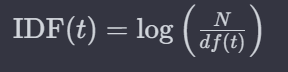

Dengan kata lain, semakin rendah frekuensi kemunculan suatu term dalam seluruh koleksi dokumen , semakin tinggi nilai IDF. Term yang muncul di lebih sedikit dokumen dianggap lebih berharga atau informatif, sehingga diberi bobot yang lebih tinggi dalam representasi TF-IDF.

In [58]:
idf = {}
w_index = 0

while w_index < len(combined_term_list):
    w = combined_term_list[w_index]
    k = 0
    i = 0

    while i < doc:
        if w in document_list[i].split():
            k += 1
        i += 1

    if k == 0:
        idf[w] = 0
        print(w + ": Dibagi 0, menjadi 0")
    else:
        idf[w] = np.log10(doc / k)
        print(w + ":" + str(idf[w]))

    w_index += 1


Streaming output truncated to the last 5000 lines.
accuraci:3.000434077479319
live:2.6994040818153375
weight:2.000434077479319
metric:2.6994040818153375
bodi:2.3983740861513563
measur:1.8543060418010806
ongol:2.6994040818153375
grade:2.523312822759656
cow:2.523312822759656
indonesian:1.4322323534123236
tropic:1.5233128227596562
anim:1.7216804765264897
agricultur:1.2928639013813823
novel:2.155336037465062
angiotensin:3.000434077479319
convert:2.3014640731432996
enzym:2.523312822759656
inhibitori:2.523312822759656
peptid:2.097344090487375
deriv:2.222282827095675
proteolyt:3.000434077479319
digest:1.921252831431694
chines:3.000434077479319
softshel:3.000434077479319
turtl:3.000434077479319
egg:2.0461915680399936
white:2.523312822759656
protein:2.0461915680399936
proteom:3.000434077479319
investig:2.6994040818153375
airborn:2.6994040818153375
submicromet:3.000434077479319
particl:2.0461915680399936
emit:2.6994040818153375
dredg:3.000434077479319
vessel:2.3983740861513563
use:0.943529226142

In [59]:
df_tf_t.values
tf_array = np.transpose(df_tf_t.values)

In [60]:
df_tf_idf = np.zeros((len(combined_term_list), doc))
j = 0

while j < len(combined_term_list):
    w = combined_term_list[j]
    i = 0

    while i < doc:
        df_tf_idf[j, i] = df_tf[w].values[i] * idf[w]
        i += 1

    j += 1

df_tf_idf = pd.DataFrame(df_tf_idf, index=list(combined_term_list), columns=["D" + str(i) for i in range(1, doc + 1)])
df_tf_idf


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D992,D993,D994,D995,D996,D997,D998,D999,D1000,D1001
genet,1.824343,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
divers,2.000434,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
gorontalo,3.000434,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
local,1.796314,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,1.796314,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
cattl,1.959041,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
regenc,0.000000,0.0,0.000000,1.959041,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.959041
west,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,2.523313
papua,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,3.000434
morpholog,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,2.097344


In [61]:
tf_idf_array = df_tf_idf.values
tf_idf_array = np.transpose(tf_idf_array)
tf_idf_array

array([[1.82434282, 2.00043408, 3.00043408, ..., 0.        , 0.        ,
        0.72859247],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.72859247],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.00043408, 2.09734409,
        0.72859247]])

### K-Means Impelentation

### testing

<H2>Cosine similarity <H2>

Cosine similarity sering digunakan untuk mengukur sejauh mana dua dokumen mirip satu sama lain berdasarkan representasi vektor mereka dalam ruang fitur. Proses ini melibatkan beberapa langkah, termasuk representasi dokumen sebagai vektor dan perhitungan cosine similarity di antara vektor-vektor ini.

Cosine similarity membantu meningkatkan akurasi klasterisasi dokumen dengan mempertimbangkan sejauh mana dokumen mirip atau berbeda dalam representasi vektor mereka



<H2>K-Means<H2>

K-Means adalah algoritma klasterisasi yang sering digunakan dalam konteks klasterisasi dokumen. Tujuan utama K-Means adalah mempartisi kumpulan data menjadi kelompok-kelompok yang homogen, di mana setiap kelompok memiliki pusat massa yang disebut sebagai centroid.  K-Means dapat digunakan untuk mengelompokkan dokumen yang mirip ke dalam kelompok yang sama. Metode ini berguna untuk mengidentifikasi kelompok dokumen dengan karakteristik serupa dan mempermudah analisis dan pengelompokan dokumen secara efisien.

In [62]:
import numpy as np

def cosine_similarity(vec1, vec2):
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0  # Return 0 when one of the vectors has zero norm to avoid division by zero

    return np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)

def kmeans_clustering(data, k, max_iters=100):
    # Randomly initialize centroids
    centroids = data[np.random.choice(len(data), k, replace=False)]

    for i in range(max_iters):
        # Assign each data point to the nearest centroid based on cosine similarity
        labels = [np.argmax([cosine_similarity(point, centroid) for centroid in centroids]) for point in data]

        # Update centroids
        new_centroids = [np.mean([data[i] for i in range(len(data)) if labels[i] == j], axis=0) for j in range(k)]

        centroids = np.array(new_centroids)

        print(i, " iterations")

    return centroids, labels

### Training

In [63]:
centroids, labels = kmeans_clustering(tf_idf_array, 10, 50)

0  iterations
1  iterations
2  iterations
3  iterations
4  iterations
5  iterations
6  iterations
7  iterations
8  iterations
9  iterations
10  iterations
11  iterations
12  iterations
13  iterations
14  iterations
15  iterations
16  iterations
17  iterations
18  iterations
19  iterations
20  iterations
21  iterations
22  iterations
23  iterations
24  iterations
25  iterations
26  iterations
27  iterations
28  iterations
29  iterations
30  iterations
31  iterations
32  iterations
33  iterations
34  iterations
35  iterations
36  iterations
37  iterations
38  iterations
39  iterations
40  iterations
41  iterations
42  iterations
43  iterations
44  iterations
45  iterations
46  iterations
47  iterations
48  iterations
49  iterations


### Avarage Silhouette Score

In [64]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(tf_idf_array, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.011953279265696318


### Detailed Silhouette Score for each cluster

<h3>Silhouette scores<h3>

Silhouette scores adalah metrik evaluasi yang digunakan untuk mengukur seberapa baik sebuah objek ditempatkan dalam klaster yang dihasilkan oleh algoritma klasterisasi, seperti K-Means. Metrik ini memberikan nilai antara -1 dan 1, di mana nilai tinggi menunjukkan bahwa objek tersebut ditempatkan dengan baik dalam klasternya dan memiliki jarak yang baik dengan klaster lain.

In [65]:
import numpy as np
from sklearn.metrics import silhouette_samples

def calculate_cluster_silhouette_scores(tf_idf_array, labels):
    # Calculate the silhouette scores for each sample
    silhouette_values = silhouette_samples(tf_idf_array, labels)

    # Calculate average silhouette score for each cluster
    avg_silhouette_scores = {}
    for i in np.unique(labels):  # Iterates over each cluster
        cluster_silhouette_vals = silhouette_values[labels == i]
        avg_silhouette_scores[i] = np.mean(cluster_silhouette_vals)

    return avg_silhouette_scores

def get_clustered_data(tf_idf_array, labels):
    # Creating a dictionary to hold data points for each cluster
    clustered_data = {}
    for i in np.unique(labels):  # Iterates over each cluster
        clustered_data[i] = tf_idf_array[labels == i]

    return clustered_data

In [66]:
avg_silhouette_scores = calculate_cluster_silhouette_scores(tf_idf_array, labels)
clustered_data = get_clustered_data(tf_idf_array, labels)

# Print average silhouette scores for each cluster
print("Average Silhouette Scores for Each Cluster:")
for cluster, score in avg_silhouette_scores.items():
    print(f"Cluster {cluster + 1}: {score}")

Average Silhouette Scores for Each Cluster:
Cluster 1: -0.0015944712689597807
Cluster 2: 0.008994098288787153
Cluster 3: -0.00976718462417886
Cluster 4: 0.020666344399384824
Cluster 5: 0.005073429549694157
Cluster 6: -0.008230416026965285
Cluster 7: 0.02282017981395474
Cluster 8: 0.04151267342894646
Cluster 9: 0.04629316352223172
Cluster 10: 0.007085711291261121


### Jumlah data dalam setiap cluster

In [67]:
def count_data_in_clusters(labels):
    # Count the number of data points in each cluster
    cluster_counts = {}
    for i in np.unique(labels):  # Iterates over each cluster
        cluster_counts[i + 1] = np.sum(labels == i)  # +1 for displaying cluster number starting from 1

    # Printing the number of data points in each cluster
    print("Number of Data Points in Each Cluster:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} data")

In [68]:
# Assuming 'labels' is already defined
count_data_in_clusters(labels)

Number of Data Points in Each Cluster:
Cluster 1: 122 data
Cluster 2: 67 data
Cluster 3: 102 data
Cluster 4: 157 data
Cluster 5: 129 data
Cluster 6: 81 data
Cluster 7: 107 data
Cluster 8: 59 data
Cluster 9: 81 data
Cluster 10: 96 data


### Isi dari setiap cluster

In [69]:
def print_data_in_clusters(document_list, labels):
    # Create a dictionary to store data for each cluster
    clustered_documents = {}
    for i in np.unique(labels):  # Iterates over each cluster
        clustered_documents[i] = []

    # Assign documents to their respective clusters
    for idx, label in enumerate(labels):
        clustered_documents[label].append(document_list[idx])

    # Printing the data in each cluster
    for cluster, documents in clustered_documents.items():
        print(f"\nCluster {cluster + 1}:")
        for doc in documents:
            print(doc)

In [70]:
print_data_in_clusters(document_list, labels)


Cluster 1:
consum prefer futur consider toward organ instant noodl evid indonesia agri onlin paper econom informat
identif analysi geotour potenti purwodadi villag malang regenc support geopark area east java aip confer proceed
belief human natur moder associ religi fundament hate case muslim indonesia appli social psycholog
understand covid vaccin hesit crosssect studi malang district indonesia frontier public health
anthropogen introduct spot barb barbod binotatu across wallac line western sulawesi indonesia biodiversita
clinic improv tumor regress parturi brain tumor intracrani bleed csection gener anesthesia case report bal anesthesiolog
structur morpholog nanocomposit membran base bacteri cellulos reinforc titanium dioxid nanoparticl aip confer proceed
morpholog poros biodegrad pvapegchitosan nanofib scaffold skin tissu engin aip confer proceed
carotid intimamedia thick type diabet mellitu patient variou risk factor combin aip confer proceed
effect flavonoid isol extract phaleria

### Visualisasi

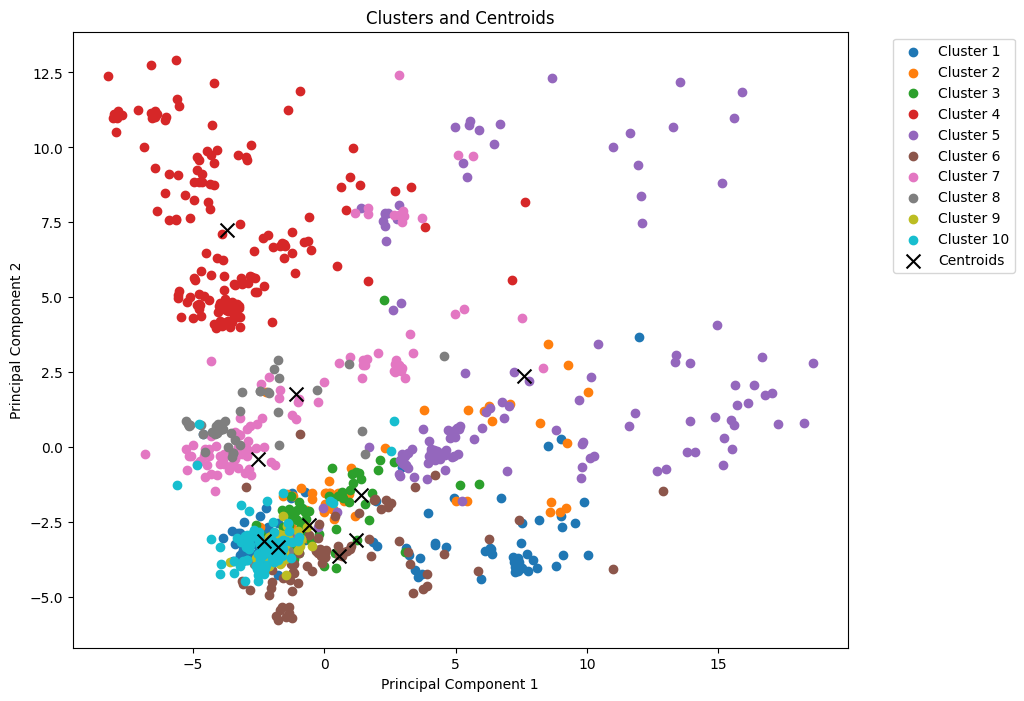

In [71]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to two components for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tf_idf_array)

# Assuming 'centroids' is an array containing the centroids of each cluster
# We will also reduce the centroids to two dimensions using PCA
reduced_centroids = pca.transform(centroids)

# Plotting the reduced data points
plt.figure(figsize=(10, 8))
for i in np.unique(labels):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'Cluster {i+1}')

# Plotting the centroids
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

# Adding the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters and Centroids')
plt.show()


### Elbow Method

Untuk melihat cluster terbaik

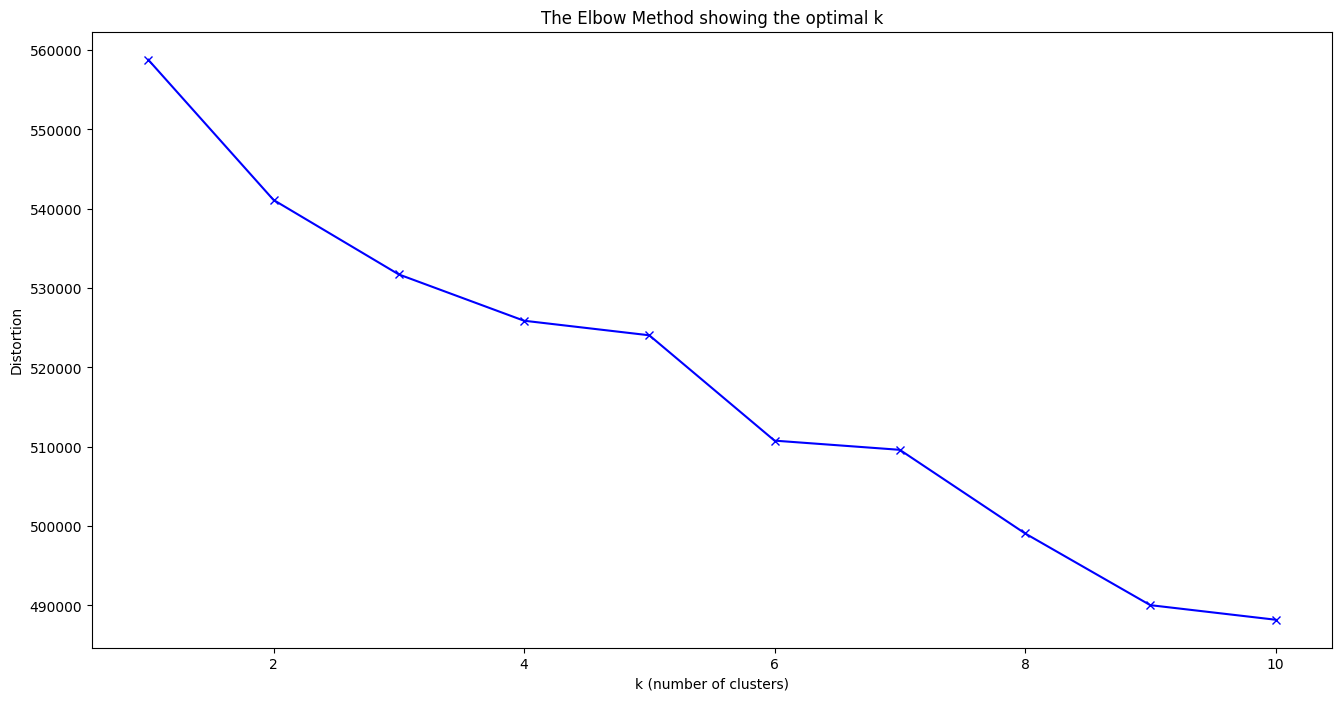

In [72]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming `tf_idf_array` is your data array
distortions = []
K = range(1, 11)  # Adjust the range of k as needed
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=42)
    kmeanModel.fit(tf_idf_array)
    distortions.append(kmeanModel.inertia_)

# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Kmeans using Library

In [73]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming `tf_idf_array` is your data array
distortions = []
K = range(1, 11)  # Adjust the range of k as needed
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeanModel.fit(tf_idf_array)
    distortions.append(kmeanModel.inertia_)

### Avg Silhouette Score using Kmeans Library

In [74]:
from sklearn.metrics import silhouette_score

# Assuming `tf_idf_array` is your data array and `kmeanModel` is already fitted with the optimal k
# Calculate the average silhouette score
optimal_k = 10  # replace with your optimal k found from the elbow method
kmeanModel_optimal = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeanModel_optimal.fit_predict(tf_idf_array)
silhouette_avg = silhouette_score(tf_idf_array, cluster_labels)
print(f"Average silhouette score for {optimal_k} clusters: {silhouette_avg}")

Average silhouette score for 10 clusters: 0.0547305809466913


### Detailed Silhouette Score for each cluster using Kmeans Library

In [75]:
from sklearn.metrics import silhouette_samples

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(tf_idf_array, cluster_labels)

# Silhouette score for each cluster
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    print(f"Silhouette score for cluster {i+1}: {np.mean(ith_cluster_silhouette_values)}")

Silhouette score for cluster 1: 0.0676276573869076
Silhouette score for cluster 2: 0.07950578699838257
Silhouette score for cluster 3: 0.02560130692665852
Silhouette score for cluster 4: 0.043608366920976534
Silhouette score for cluster 5: 0.12217963106517442
Silhouette score for cluster 6: -0.027237500114847085
Silhouette score for cluster 7: 0.08727732082475344
Silhouette score for cluster 8: 0.157949848388388
Silhouette score for cluster 9: 0.051341118232387795
Silhouette score for cluster 10: 0.10543182684597549


### Numbers of data in each cluster using Kmeans Library

In [76]:
# Count the data points in each cluster
value_counts = np.bincount(cluster_labels)
cluster_counts = {i: count for i, count in enumerate(value_counts, start=1)}

# Print the number of data points in each cluster
print("Number of data points in each cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")

Number of data points in each cluster:
Cluster 1: 47 data points
Cluster 2: 33 data points
Cluster 3: 104 data points
Cluster 4: 104 data points
Cluster 5: 48 data points
Cluster 6: 60 data points
Cluster 7: 72 data points
Cluster 8: 27 data points
Cluster 9: 487 data points
Cluster 10: 19 data points


### Data in each cluster using Kmeans Library

In [77]:
# Assuming 'document_list' corresponds to the documents in 'tf_idf_array'
def print_data_in_clusters(document_list, labels):
    # Create a dictionary to store documents for each cluster
    clustered_documents = {i+1: [] for i in np.unique(labels)}  # +1 to adjust cluster numbering

    # Assign documents to their respective clusters
    for idx, label in enumerate(labels):
        clustered_documents[label+1].append(document_list[idx])  # +1 to adjust cluster numbering

    # Printing the documents in each cluster
    for cluster, documents in clustered_documents.items():
        print(f"\nCluster {cluster}:")
        for doc in documents:
            print(doc)

# Call the function to print documents in each cluster
print_data_in_clusters(document_list, cluster_labels)


Cluster 1:
numer solut timedepend schrdinger equat multiphoton process matrix iter method physic review atom molecular optic physic
phase control autlertown doublet ioniz continuum twocolor laser field physic review atom molecular optic physic
total ioniz rate ion yield atom nonperturb laser intens physic review atom molecular optic physic
swing effect spatial inhomogen nl soliton nonlinear optic physic materi
deform modul wave group thirdord nonlinear media optic quantum electron
satur nonlinear suscept nobl ga atom intens laser field pacif rim confer laser electroopt cleo technic digest
finit element scheme studi nonlinear optic respons finit grate without defect optic quantum electron
propag dynam femtosecond laser puls hollow fiber fill argon constant ga pressur versu differenti ga pressur optic societi america b optic physic
ionizationinduc highord nonlinear suscept physic review atom molecular optic physic
propag dynam femtosecond laser puls argon physic review atom molecular op

### Scatter Plot Kmeans using Library

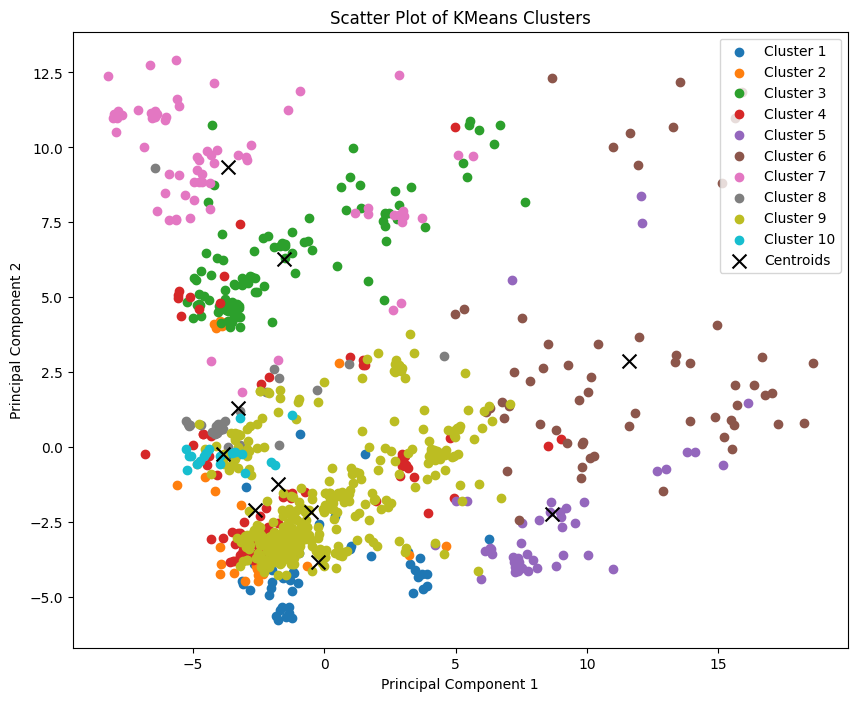

In [78]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Run KMeans to cluster your data
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=42)
labels = kmeans.fit_predict(tf_idf_array)

# Step 2: Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tf_idf_array)

# Step 3: Plot the projected data points
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
for i in unique_labels:
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'Cluster {i+1}')

# Step 4: Calculate the centroids for the projected data and plot them
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of KMeans Clusters')
plt.legend()
plt.show()


### Elbow Method Kmeans using Library

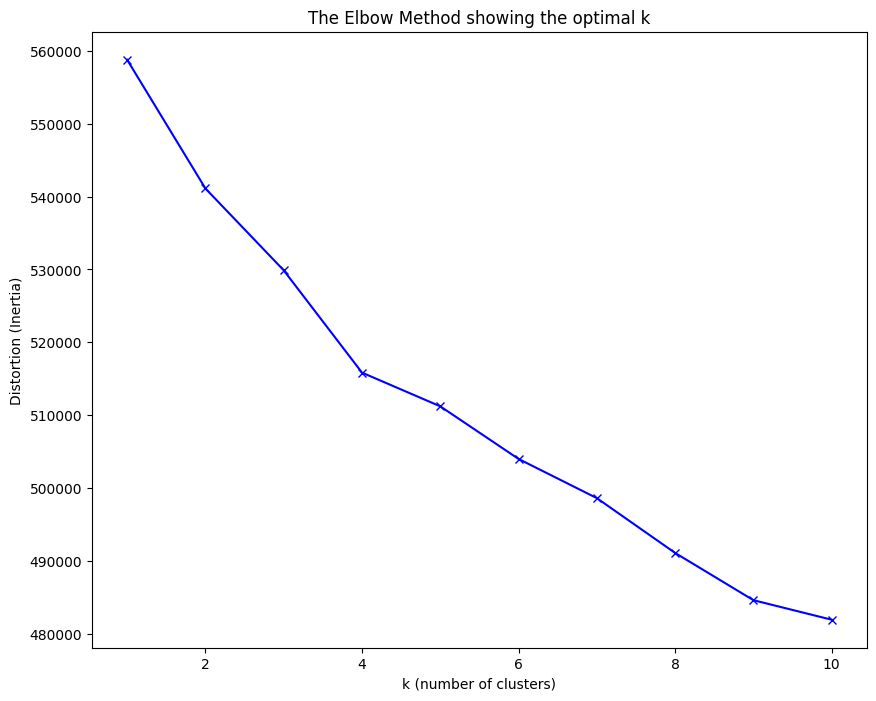

In [79]:
# Plotting the distortions
plt.figure(figsize=(10, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Distortion (Inertia)')
plt.title('The Elbow Method showing the optimal k')
plt.show()
